In [36]:
''' required import '''

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import pytesseract

In [37]:
''' noise reducer '''

def noiseReducer(img):
    img = np.array(img)
    img = cv2.GaussianBlur(img, (7, 7), 0)
    img = Image.fromarray(img, 'RGB')
    return img

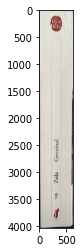

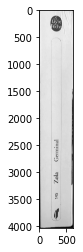

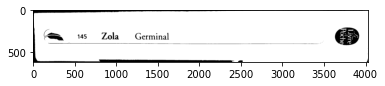

 
     
 

Zola

Germinal



In [52]:
''' book spine processing '''

# constraint : 
# the book must be oriented at 90°

# image load
img = Image.open('../image/bookSpine/3.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)


"""
img : image of a book spine
return : book's information
"""
def bookSpineProcessing(img):
    
    width, height = img.size
    
    # gray converter
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # binarisation
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # noise reducer
    img = cv2.GaussianBlur(binary, (7, 7), 0)
    img = Image.fromarray(img)
    
    # rotation
    rotate = img.rotate(-90, expand = 1)
    plt.imshow(rotate, cmap='gray')
    plt.show()
    
    # OCR
    text = pytesseract.image_to_string(rotate)
    print(text)
    
    return None

# show result
bookSpineProcessing(img)

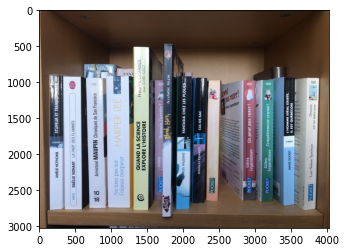

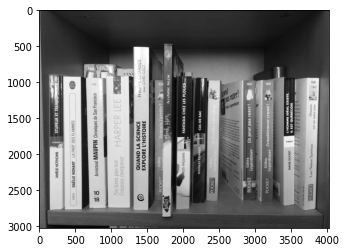

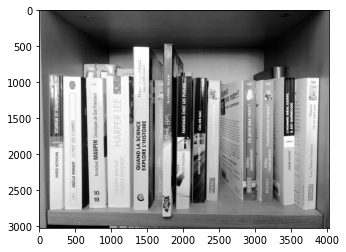

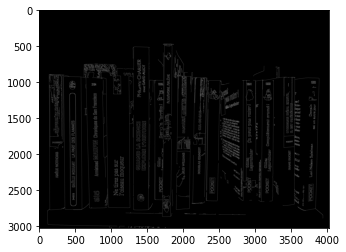

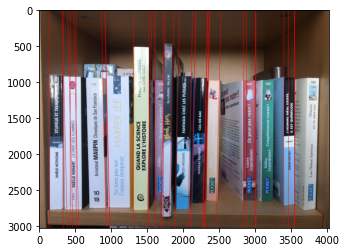

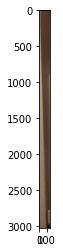

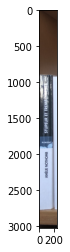

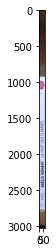

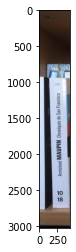

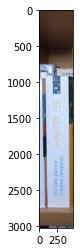

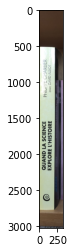

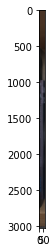

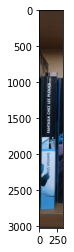

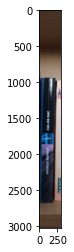

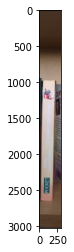

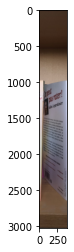

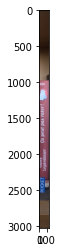

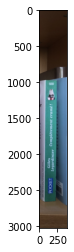

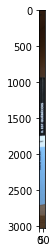

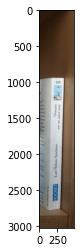

In [39]:
''' row segmentation '''

# constraint : 
# doesn't work with thin book spines 
# it's much better with vertical books

# image load
img = Image.open('../image/bookRow/5.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

"""
img : image of a book row
return : list of book spines
"""
def rowSegmentation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    coordinate.append((0,0))
    for line in lines:
        for rho,theta in line:
            if theta<np.pi/2-0.2 or np.pi/2+0.2<theta:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + width*(-b))
                y1 = int(y0 + height*(a))
                x2 = int(x0 - width*(-b))
                y2 = int(y0 - height*(a))
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((x1,x2))
    coordinate.append((width,width))
    plt.imshow(houghTransform)
    plt.show()
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = width/50
    for x1,x2 in coordinate:
        if (last != None and last<min(x1,x2)-threshold):
            croppedImg.append(img.crop((last, 0, max(x1,x2), height)))
        last = min(x1,x2)
    
    return croppedImg

# show result
images = rowSegmentation(img)
for im in images:
    plt.imshow(im)
    plt.show()

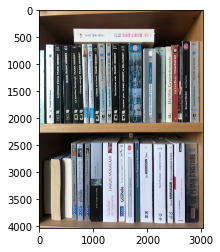

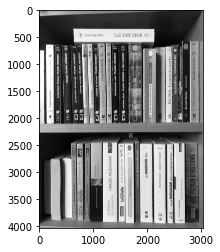

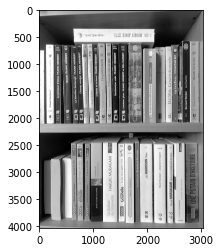

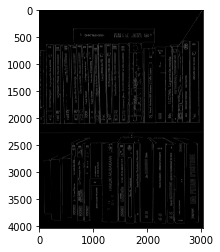

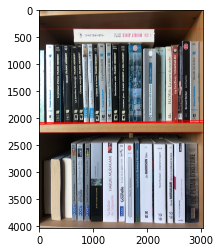

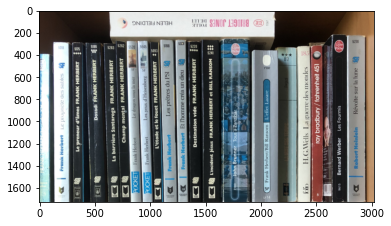

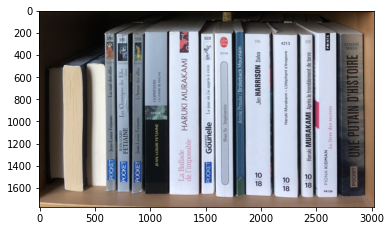

In [40]:
''' bookshelf segmentation '''

# constraint : 
# doesn't work with thin book spines 
# doesn't work with low definition image

# image load
img = Image.open('../image//bookshelf/3.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)


"""
img : image of a vertical bookshelf
return : list of book rows
"""
def bookshelfSegmentation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.Canny(gray, 50, 200)
    plt.imshow(edges, cmap='gray')
    plt.show()

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    coordinate.append(0)
    for line in lines:
        for rho,theta in line:
            if np.pi/2-0.1<theta and theta<np.pi/2+0.1:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + width*(-b))
                y1 = int(y0 + height*(a))
                x2 = int(x0 - width*(-b))
                y2 = int(y0 - height*(a))
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((y1+y2)//2)
    coordinate.append(height)
    plt.imshow(houghTransform)
    plt.show()

    # crop image
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = height/10
    for y in coordinate:
        if (last != None and last<y-threshold):
            croppedImg.append(img.crop((0, last, width, y)))
        last = y
    
    return croppedImg

# show result
images = bookshelfSegmentation(img)
for im in images:
    plt.imshow(im)
    plt.show()

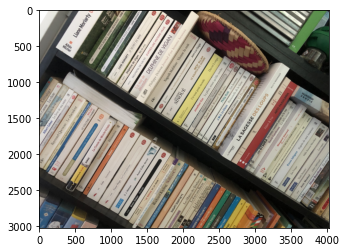

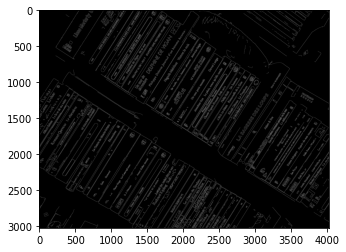

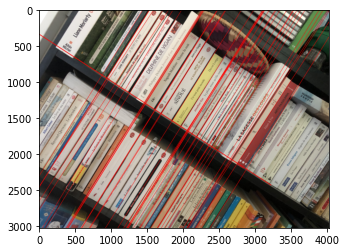

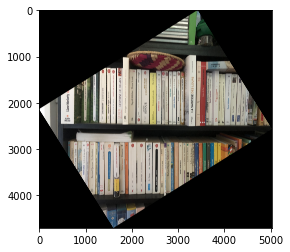

In [41]:
''' bookshelf orientation '''

# constraint : 
# the majority of the books must be well oriented
# the image should not be too askew

# image load
img = Image.open('../image/askewBookshelf/1.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

"""
img : askew image of bookshelf
return : reoriented image
"""
def bookshelfOrientation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    treshold = 500
    lines = cv2.HoughLines(edges, 1, np.pi/180, treshold)
    length = max(width, height)
    angles = []
    houghTransform = img.copy()
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + length*(-b))
            y1 = int(y0 + length*(a))
            x2 = int(x0 - length*(-b))
            y2 = int(y0 - length*(a))
        
            houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
            angles.append(theta)

    plt.imshow(houghTransform)
    plt.show()
    
    # orientation
    angles.sort()
    theta = angles[len(angles)//2]
    theta = math.degrees(theta)
    if theta>90:
        theta = theta - 180
    img = Image.fromarray(img, 'RGB')
    img = img.rotate(theta, expand = 1)
    
    return img

# show result
img = bookshelfOrientation(img)
plt.imshow(img)
plt.show()

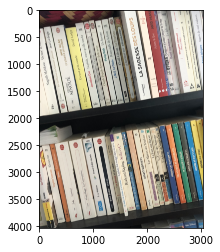

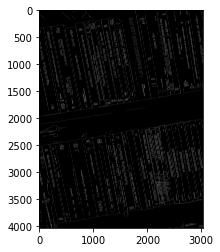

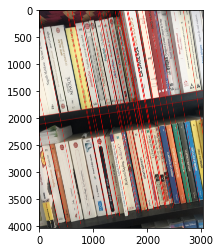

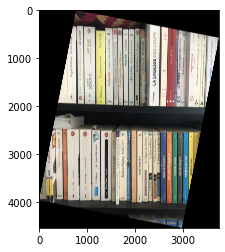

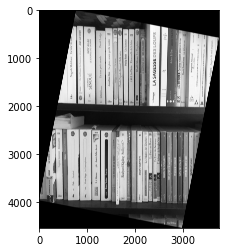

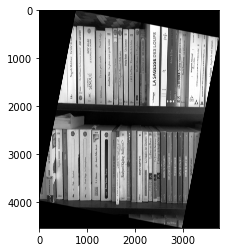

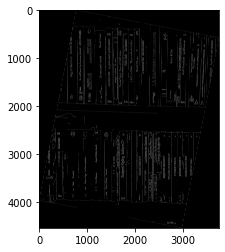

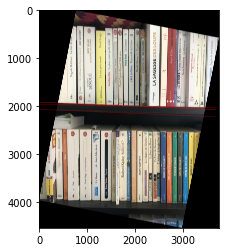

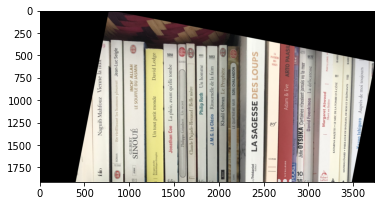

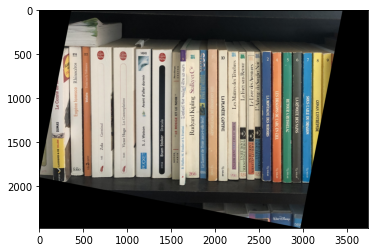

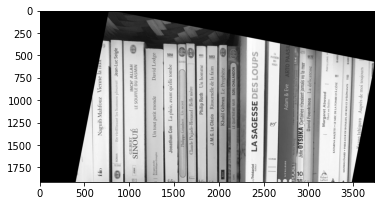

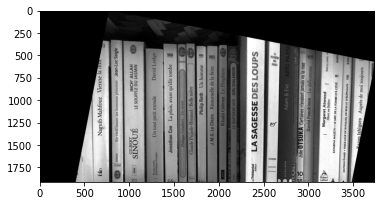

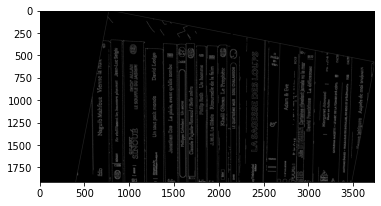

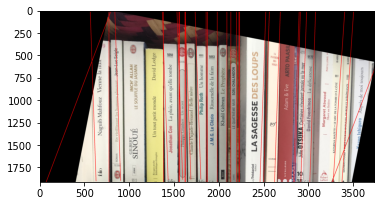

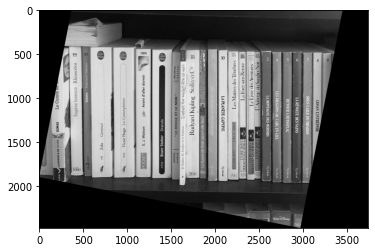

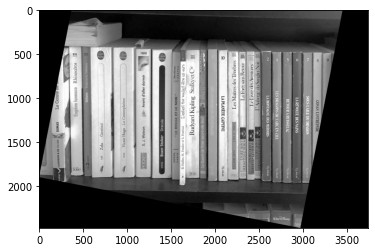

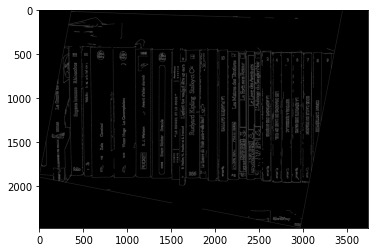

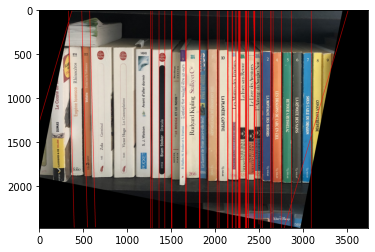

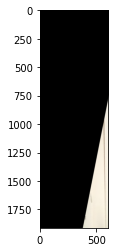

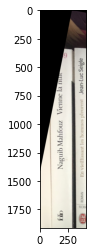

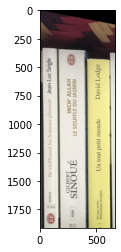

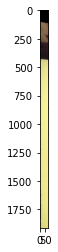

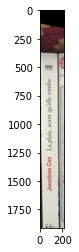

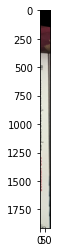

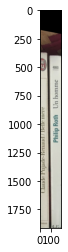

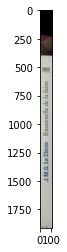

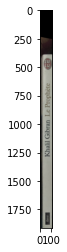

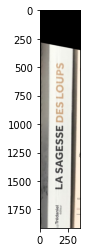

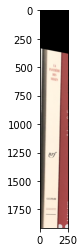

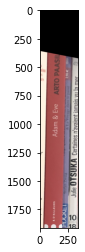

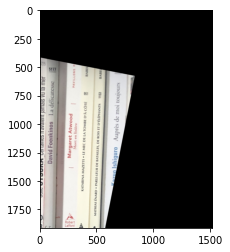

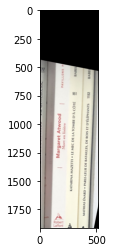

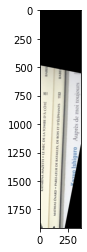

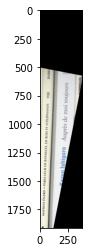

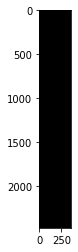

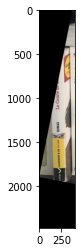

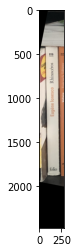

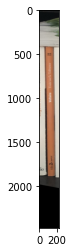

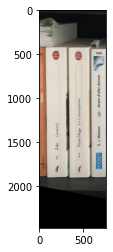

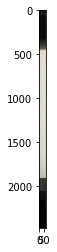

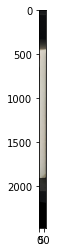

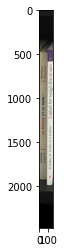

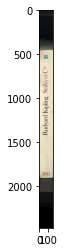

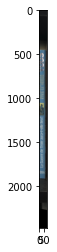

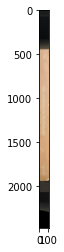

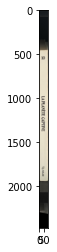

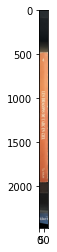

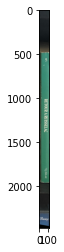

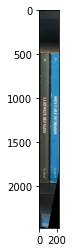

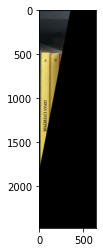

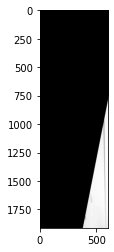

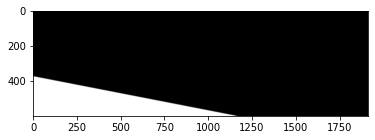

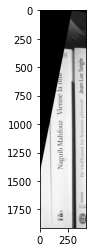

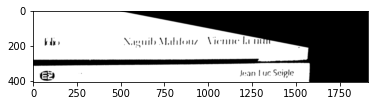

 
  
 
   

 

Nawuib Mahfouz Viewne lant

 

Jean Luc Seigle



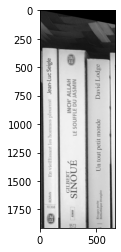

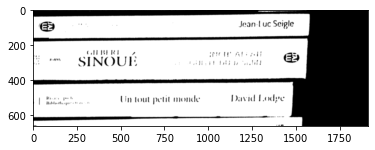

   
  

Jean-tuc Seigle

   
  
   
 

GHBERE > rie tet mba df

SINOUEL

Un tout petit monde David Lodge

   

 



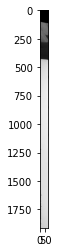

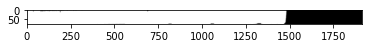

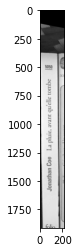

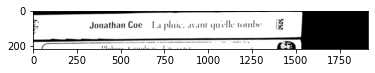

vr r—yy

      
 

Jonathan Coe La pluic. avant quelle tombe IZ

os



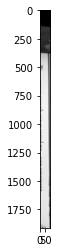

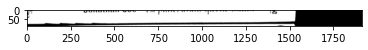

WAAAFTERE Re eSere Ne a -08 preees hE OOS IS BEE”

    



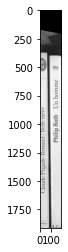

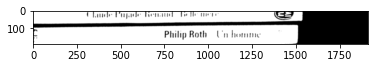

( fant Propaede Deena Dee dhe tiers

    

 

    

Un homme

Philip Roth



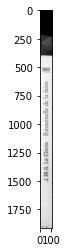

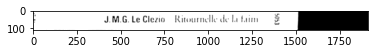

J.M.G. Le Clezio

Ritournelle de la faim

£505



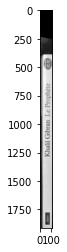

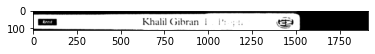

    

Khalil Gibran |



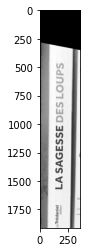

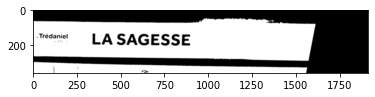

  
   
 

   

Trédaniel LA SAG ESSE



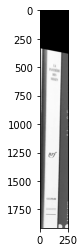

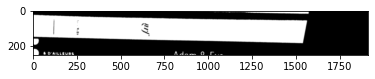

  

> 4 O AULLEUeS Ad... O fF...



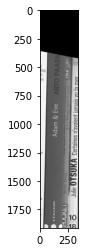

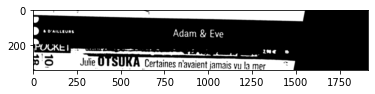

eorrree Xe Lm a

 



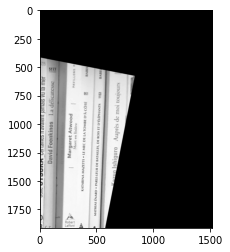

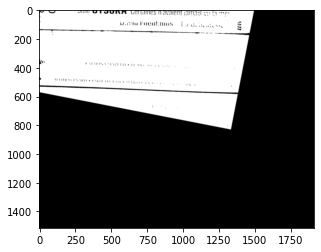

PtdineS N avaien

vaviu roenkinos

 



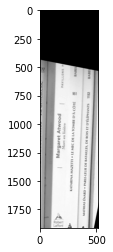

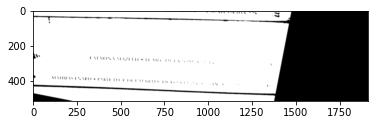

i
Ris tia cha NN

 



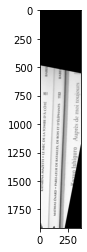

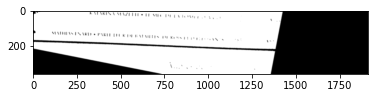

       
  

»** HATNKINV MAZE DEE ae SULO EE EN Leer

   

       

SUNERIINN EN QE? ot \kil

thik



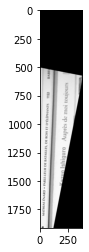

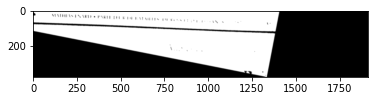

SUNEEEEAS EN ViEd © peg

 



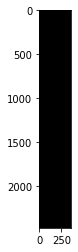

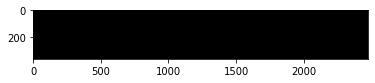

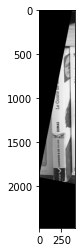

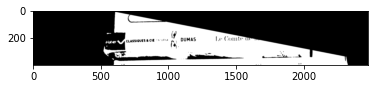

(y

CLASSIQUES BCIE SH Hf f DUMAS Le Comte
4

i$

 



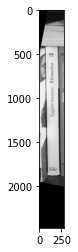

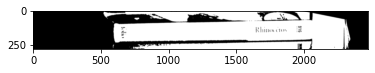

Ri mneccros a

 
 
  

 
 



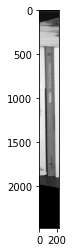

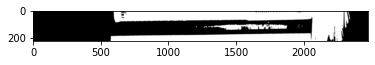

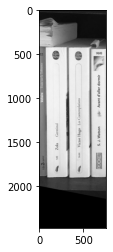

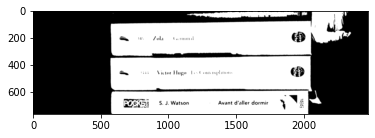

 

Victor Plug bes Centerport

       

6.0" =I S. J. Watson Avant d’aller dormir ' “ & By

Rees



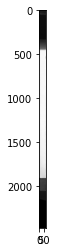

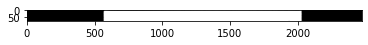

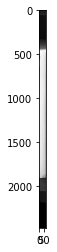

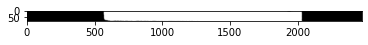

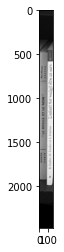

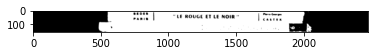

saors Prose. Geer ges

“LE ROUGE ET LE NOIR”

rPaARIS Caeten

 



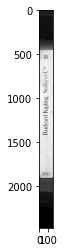

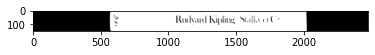

Rudvard Kapling Stalhy ciG



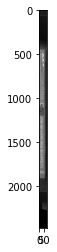

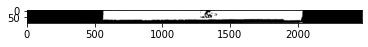

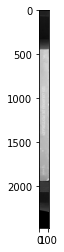

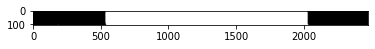

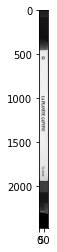

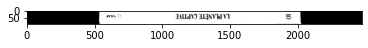

JALLAVD SLINV]d V1

ol



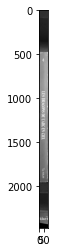

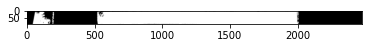

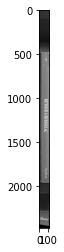

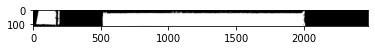

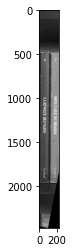

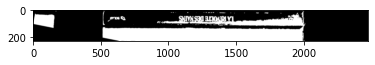

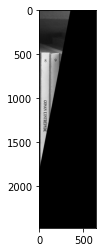

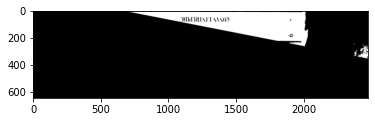

In [53]:
''' all process '''

# image load
img = Image.open('../image/askewBookshelf/4.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

# orientation
reoriented = bookshelfOrientation(img)
plt.imshow(reoriented)
plt.show()

# bookshelf segmentation
rows = bookshelfSegmentation(reoriented)
for im in rows:
    plt.imshow(im)
    plt.show()

# row segmentation
books = []
for im in rows:
    spines = rowSegmentation(im)
    books = books + spines
for book in books:
    plt.imshow(book)
    plt.show()

# book spine processing
for book in books:
    bookSpineProcessing(book)